In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point

from mpl_toolkits.axes_grid1 import make_axes_locatable
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from sklearn.neighbors import DistanceMetric
from math import radians

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


from sklearn import svm
from sklearn import metrics


from sklearn.datasets import make_moons, make_blobs
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, classification_report, make_scorer, recall_score, f1_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

In [4]:
df = pd.read_csv("weatherAUS.csv")
aus_town_gps = pd.read_csv("aus_town_gps.csv",sep=",")
climatsaus = pd.read_csv("climatsAUS_v2.csv",sep=";")

In [8]:
df.describe(include='object')

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,145460,145460,135134,134894,141232,142199,142193
unique,3436,49,16,16,16,2,2
top,2013-11-12,Canberra,W,N,SE,No,No
freq,49,3436,9915,11758,10838,110319,110316


In [9]:
#Attribution de la classe de climat (classification de Köppen) pour chaque ville
climatsaus.head()

,Location,Climat_Koppen
0,Uluru,BSh
1,Woomera,Bwh
2,Adelaide,Csa
3,Albany,Csb
4,MountGambier,Csb


In [10]:
# Pour simplifier, on regroupe les climats en 4 catégories : chaud_humide, tempéré_froid, sec et méditerranéen. On pourra ainsi faire des visualisations plus facilement.

climats_type = {'Am':'chaud_humide',
                'Aw':'chaud_humide',
                'Cfa':'chaud_humide',
                'Cfb':'tempéré_froid', 
                'Cfc':'tempéré_froid', 
                'BSh':'sec',
                'BSk':'sec',
                'Bsk':'sec', 
                'Bwh':'sec',
                'Csa':'méditerranéen',
                'Csb':'méditerranéen'              
               }

climatsaus['Clim_type']=climatsaus['Climat_Koppen'].map(climats_type)


In [11]:
#Fusion des dataframes

df = pd.merge(df, aus_town_gps, how='left', left_on="Location",right_on="Location")
df = pd.merge(df, climatsaus, how='left', left_on="Location",right_on="Location")
df.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Latitude,Longitude,Climat_Koppen,Clim_type
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,8.0,NaN,16.9,21.8,No,No,-36.065766,146.910315,Cfa,chaud_humide
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,NaN,NaN,17.2,24.3,No,No,-36.065766,146.910315,Cfa,chaud_humide
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,NaN,2.0,21.0,23.2,No,No,-36.065766,146.910315,Cfa,chaud_humide
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,NaN,NaN,18.1,26.5,No,No,-36.065766,146.910315,Cfa,chaud_humide
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,7.0,8.0,17.8,29.7,No,No,-36.065766,146.910315,Cfa,chaud_humide
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,NaN,NaN,20.6,28.9,No,No,-36.065766,146.910315,Cfa,chaud_humide
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,...,1.0,NaN,18.1,24.6,No,No,-36.065766,146.910315,Cfa,chaud_humide
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,NaN,NaN,16.3,25.5,No,No,-36.065766,146.910315,Cfa,chaud_humide
8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,...,NaN,NaN,18.3,30.2,No,Yes,-36.065766,146.910315,Cfa,chaud_humide
9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,...,NaN,NaN,20.1,28.2,Yes,No,-36.065766,146.910315,Cfa,chaud_humide


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145460 entries, 0 to 145459
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [13]:
#création de quelques variables de date et conversion de raintoday et raintomorrow en numériques
df['RainToday_Num'] = (df['RainToday'] ==  'Yes')*1
df['RainTomorrow_Num'] = (df['RainTomorrow'] ==  'Yes')*1
df['Date'] = pd.to_datetime(df['Date'])
df['Mois'] = df['Date'].dt.month
df['Trimestre'] = df['Date'].dt.quarter
df['Annee'] = df['Date'].dt.year

In [14]:
#création d'un dictionnaire associant la direction du vent à l'angle correspondant (en degrés) sur le cercle trigonométrique (ie. E=0° et rotation dans le sens direct)
angles = {'E':0, 
          'ENE':22.5, 
          'NE':45, 
          'NNE':67.5, 
          'N':90, 
          'NNW':112.5, 
          'NW':135, 
          'WNW':157.5, 
          'W':180, 
          'WSW':202.5, 
          'SW':225, 
          'SSW':247.5, 
          'S':270, 
          'SSE':292.5, 
          'SE':315, 
          'ESE':337.5}

In [15]:
#ajout des variables indiquant l'angle du vent au DF
df['WindGust_Ang']=df['WindGustDir'].map(angles)
df['Wind9am_Ang'] = df['WindDir9am'].map(angles)
df['Wind3pm_Ang'] = df['WindDir3pm'].map(angles)

#ajout de variables correspondant au cosinos de l'angle (abscisse des coordonnées trigo). Un cosinus négatif correspond à un vent d'ouest, un cosinus positif à un vent d'est.
df['WindGust_cos'] = np.cos(np.radians(df['WindGust_Ang']))
df['Wind9am_cos'] = np.cos(np.radians(df['Wind9am_Ang']))
df['Wind3pm_cos'] = np.cos(np.radians(df['Wind3pm_Ang']))

#ajout de variables correspondant au sinus de l'angle (ordonnée des coordonnées trigo). Un sinus négatif correspond à un vent de sud, un sinus positif à un vent de nord.
df['WindGust_sin'] = np.sin(np.radians(df['WindGust_Ang']))
df['Wind9am_sin'] = np.sin(np.radians(df['Wind9am_Ang']))
df['Wind3pm_sin'] = np.sin(np.radians(df['Wind3pm_Ang']))

In [16]:
df["LogRainfall"] = np.log(df["Rainfall"])
df["LogEvaporation"] = np.log(df["Evaporation"])

df= df.sort_values(["Location","Date"])
df["Rain_J-1"] = df["RainToday_Num"].shift(1)
df["Rain_J-2"] = df["RainToday_Num"].shift(2)
df["Rain_J+2"] = df["RainToday_Num"].shift(-2)
df["Rain_J+3"] = df["RainToday_Num"].shift(-3)

C:\Users\alain\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\alain\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:
df.describe()

C:\Users\alain\anaconda3\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Wind3pm_cos,WindGust_sin,Wind9am_sin,Wind3pm_sin,LogRainfall,LogEvaporation,Rain_J-1,Rain_J-2,Rain_J+2,Rain_J+3
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,...,1.412320e+05,135134.000000,1.348940e+05,141232.000000,1.421990e+05,8.267000e+04,145459.000000,145458.000000,145458.000000,145457.000000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,...,-1.928497e-02,-0.048253,1.386142e-02,-0.047700,-inf,-inf,0.219168,0.219170,0.219163,0.219164
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,...,7.110977e-01,0.700723,7.195379e-01,0.701213,NaN,NaN,0.413684,0.413685,0.413681,0.413682
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-inf,-inf,0.000000,0.000000,0.000000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,...,-7.071068e-01,-0.707107,-7.071068e-01,-0.707107,NaN,9.555114e-01,0.000000,0.000000,0.000000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,...,-1.836970e-16,0.000000,1.224647e-16,0.000000,NaN,1.568616e+00,0.000000,0.000000,0.000000,0.000000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,...,7.071068e-01,0.707107,7.071068e-01,0.707107,-2.231436e-01,2.001480e+00,0.000000,0.000000,0.000000,0.000000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,...,1.000000e+00,1.000000,1.000000e+00,1.000000,5.916202e+00,4.976734e+00,1.000000,1.000000,1.000000,1.000000


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145460 entries, 96320 to 108570
Data columns (total 47 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              145460 non-null  datetime64[ns]
 1   Location          145460 non-null  object        
 2   MinTemp           143975 non-null  float64       
 3   MaxTemp           144199 non-null  float64       
 4   Rainfall          142199 non-null  float64       
 5   Evaporation       82670 non-null   float64       
 6   Sunshine          75625 non-null   float64       
 7   WindGustDir       135134 non-null  object        
 8   WindGustSpeed     135197 non-null  float64       
 9   WindDir9am        134894 non-null  object        
 10  WindDir3pm        141232 non-null  object        
 11  WindSpeed9am      143693 non-null  float64       
 12  WindSpeed3pm      142398 non-null  float64       
 13  Humidity9am       142806 non-null  float64       
 14  

In [20]:
#On supprime toutes les observations avec des NA pour le moment
df1 = df.dropna()

labelencoder = LabelEncoder()
df1['Clim_type1'] = labelencoder.fit_transform(df1['Clim_type'])

#Pour les algos de detection d'anomalie, la convention est de mettre -1 pour la modalité à détecter*/

df1["Class"] = df1["RainTomorrow_Num"]
df1['Class'].replace({1: -1}, inplace=True)
df1['Class'].replace({0: 1}, inplace=True)


features = ["RainToday_Num","Rain_J-1","Rain_J-2","MinTemp","MaxTemp","Mois","Sunshine","Evaporation",
            "Humidity3pm","Humidity9am","Pressure9am","Pressure3pm","Cloud3pm","Cloud9am", 
            "Wind9am_cos","Wind3pm_cos","WindGust_cos","Wind9am_sin","Wind3pm_sin","WindGust_sin", "Clim_type1"]

target = df1["RainTomorrow_Num"]
target_ano = df1["Class"]
data = df1[features]

C:\Users\alain\AppData\Local\Temp\ipykernel_63008\4040393825.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Clim_type1'] = labelencoder.fit_transform(df1['Clim_type'])
C:\Users\alain\AppData\Local\Temp\ipykernel_63008\4040393825.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["Class"] = df1["RainTomorrow_Num"]
C:\Users\alain\AppData\Local\Temp\ipykernel_63008\4040393825.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

In [22]:
X_train, X_test, y_train, y_test, y_train_ano, y_test_ano = train_test_split(data, target, target_ano, test_size=0.2, random_state=123)

In [23]:
#Grille de recherche pour avoir les meilleurs hyperparametres pour le criterion et max_depth.

param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15),'min_samples_split':[300],'min_samples_leaf':[100]}
nfolds = 3

resc_dt = make_scorer(f1_score,pos_label=1)

# decision tree model
dtree_model=DecisionTreeClassifier()
#use gridsearch to test all values
dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds, scoring=resc_dt)
#fit model to data
dtree_gscv.fit(X_train, y_train)

dtree_gscv.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 100,
 'min_samples_split': 300}

In [24]:
#Création de l'arbre avec les meilleurs hyperparametres calcules ci dessus

dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=7,random_state=123,)
dt_clf.fit(X_train , y_train)

DecisionTreeClassifier(max_depth=7, random_state=123)

In [25]:
y_pred = dt_clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

## Méthode 2 : à l'aide de pandas
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Accuracy: 0.8457107408720312


Classe prédite,0,1
Classe réelle,,
0,8313,482
1,1259,1230


In [26]:
feats = {}
for feature, importance in zip(data.columns, dt_clf.feature_importances_):
    feats[feature] = importance 
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)

,Importance
Humidity3pm,0.631787
Sunshine,0.162980
Pressure3pm,0.122179
Clim_type1,0.015025
RainToday_Num,0.014775
Wind9am_sin,0.009802
MaxTemp,0.009582
Pressure9am,0.006976


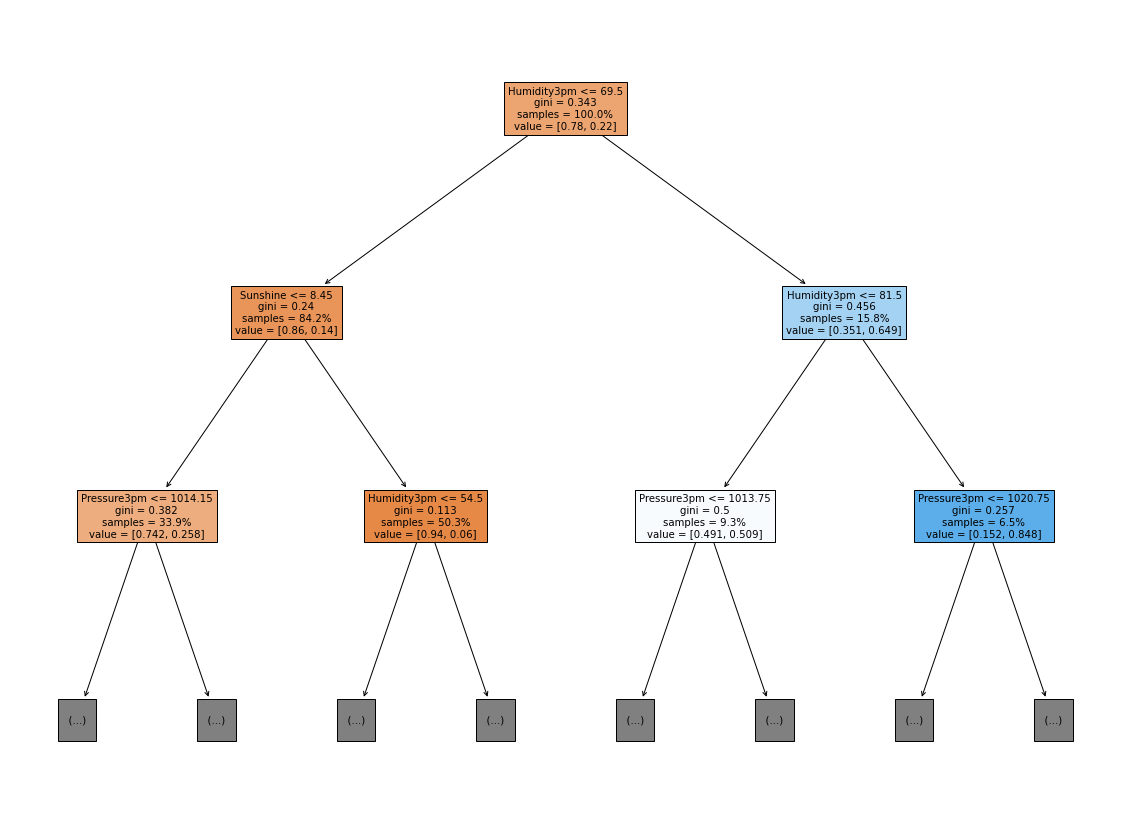

In [27]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(20,15))
plot_tree(dt_clf,feature_names = list(features),filled=True,proportion=True,max_depth=2)
plt.show()

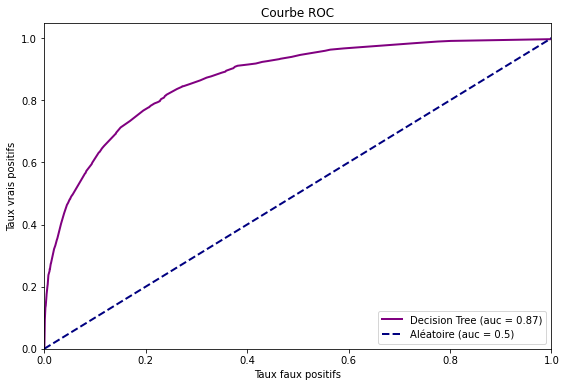

In [28]:
probs_dt = dt_clf.predict_proba(X_test)

fpr_dt, tpr_dt, seuils_dt = roc_curve(y_test,probs_dt[:,1],pos_label=1)
#fpr1, tpr1, seuils1 = det_curve(y_test,probs[:,1],pos_label=1)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(fpr_dt, tpr_dt, color='purple', lw=2, label='Decision Tree (auc = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")

In [29]:
ac = AdaBoostClassifier(base_estimator=dt_clf,n_estimators=400)
ac.fit(X_train , y_train)
ac.score(X_test, y_test)

0.8437610776320453

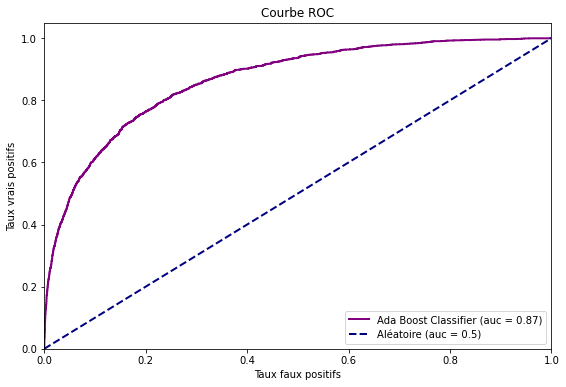

In [30]:
probs_ada = ac.predict_proba(X_test)

fpr_ada, tpr_ada, seuils_ada = roc_curve(y_test,probs_ada[:,1],pos_label=1)
roc_auc_ada = auc(fpr_ada, tpr_ada)

plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(fpr_ada, tpr_ada, color='purple', lw=2, label='Ada Boost Classifier (auc = %0.2f)' % roc_auc_ada)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")

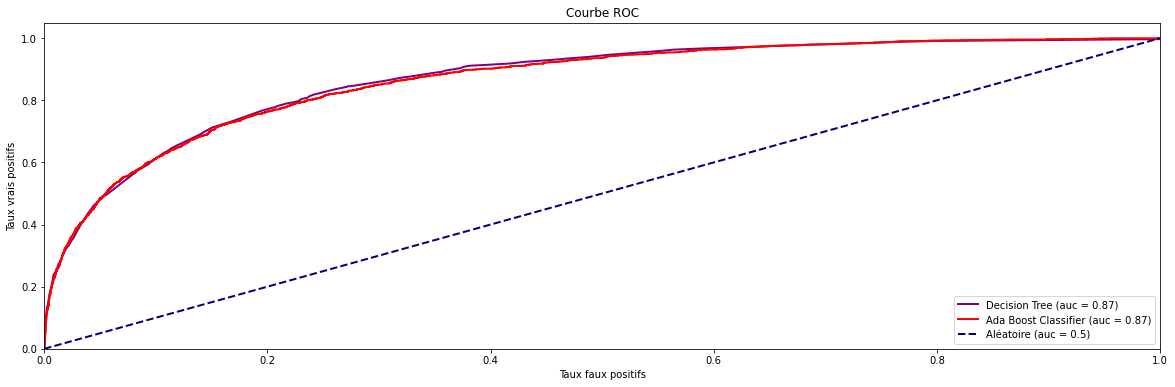

In [31]:
plt.figure(figsize=(20,6))
plt.plot(fpr_dt, tpr_dt, color='purple', lw=2, label='Decision Tree (auc = %0.2f)' % roc_auc_dt)
plt.plot(fpr_ada, tpr_ada, color='red', lw=2, label='Ada Boost Classifier (auc = %0.2f)' % roc_auc_ada)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")